In [ ]:
!pip install ultralytics opencv-python-headless pycocotools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from ultralytics import YOLO

import matplotlib.pyplot as plt
import cv2
import json
from google.colab.patches import cv2_imshow
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np

# yolov8l.pt | yolov8m.pt
model = YOLO('yolov8n.pt')
model2 = YOLO('yolov8m.pt')
model3 = YOLO('yolov8l.pt')

In [ ]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb


def detect_people(image, model):
    results = model(image)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    scores = results[0].boxes.conf.cpu().numpy()
    classes = [model.names[int(cls)] for cls in results[0].boxes.cls.cpu().numpy()]
    return boxes, scores, classes

def create_predictions(image_path, model):
    image = load_image(image_path)
    boxes, scores, classes = detect_people(image, model)
    predictions = []
    for i, box in enumerate(boxes):
        prediction = {
            "image_id": 1,
            "category_id": 1,
            "bbox": [box[0], box[1], box[2] - box[0], box[3] - box[1]],
            "score": float(scores[i])
        }
        predictions.append(prediction)

    with open('/content/drive/MyDrive/datatest/predictions.json', 'w') as f:
        json.dump(predictions, f)


def detect_and_annotate(image_path, model, output_image_path, output_json_path):
    image = load_image(image_path)
    boxes, scores, classes = detect_people(image, model)

    predictions = []
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        label = f"{classes[i]}: {scores[i]:.2f}"

        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
        cv2.putText(image, label, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        prediction = {
            "image_id": int(1),  # Sesuaikan dengan ID gambar yang benar
            "category_id": int(1),  # Sesuaikan dengan ID kategori yang benar
            "bbox": [float(x_min), float(y_min), float(x_max - x_min), float(y_max - y_min)],  # [x_min, y_min, width, height]
            "score": float(scores[i])  # Confidence score
        }
        predictions.append(prediction)

    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_image_path, image_bgr)

    with open(output_json_path, 'w') as f:
        json.dump(predictions, f, indent=4)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()



def draw_boxes(image, boxes, classes):
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box[:4]
        label = classes[i]
        if(label == "person"):
          cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
          cv2.putText(image, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    return image

def display_image(image):
    if isinstance(image, np.ndarray) and image.dtype == np.uint8:
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    else:
        raise TypeError("Gambar harus berupa array numpy dengan tipe data uint8")

def process_video(video_path, model, output_path='output_video.avi'):
    cap = cv2.VideoCapture(video_path)

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        boxes, classes = detect_people(frame_rgb, model)

        frame_with_boxes = draw_boxes(frame_rgb, boxes, classes)

        frame_bgr = cv2.cvtColor(frame_with_boxes, cv2.COLOR_RGB2BGR)

        out.write(frame_bgr)

    cap.release()
    out.release()




def display_video(video_path):
    video = open(video_path, "rb").read()
    video_b64 = b64encode(video).decode()

    video_tag = f'''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{video_b64}" type="video/mp4">
    </video>
    '''

    return HTML(video_tag)


0: 384x640 17 persons, 3 handbags, 1745.0ms
Speed: 3.8ms preprocess, 1745.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 3 handbags, 1715.2ms
Speed: 6.6ms preprocess, 1715.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


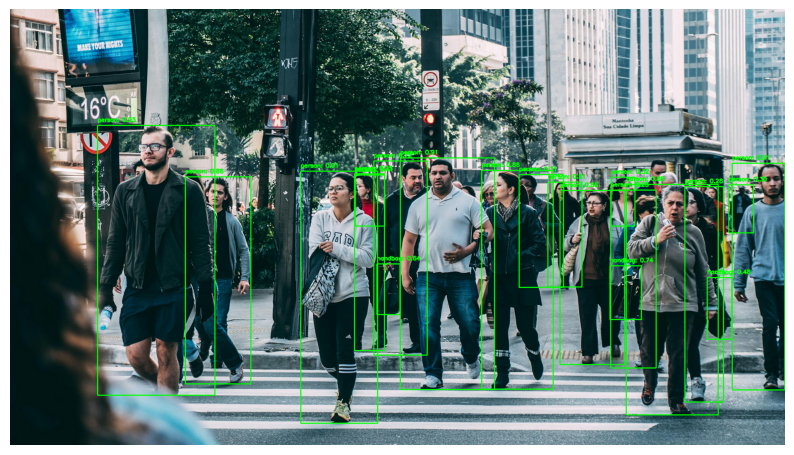

In [ ]:
image_path = '/content/drive/MyDrive/datatest/walkpeople2.jpg'
output_json_path = '/content/drive/MyDrive/datatest/predictions.json'
image = load_image(image_path)
boxes, scores, classes = detect_people(image, model3)
image_with_boxes = draw_boxes(image.copy(), boxes, classes)
#display_image(image_with_boxes)


image_path = '/content/drive/MyDrive/datatest/walkpeople2.jpg'
output_image_path = '/content/drive/MyDrive/datatest/walkpeople2_annotated.jpg'

detect_and_annotate(image_path, model3, output_image_path, output_json_path)



0: 384x640 17 persons, 3 handbags, 5173.5ms
Speed: 4.2ms preprocess, 5173.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


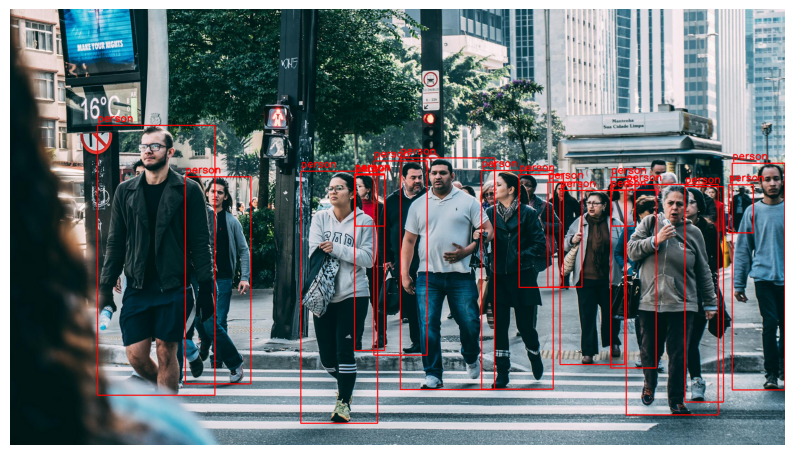

In [ ]:
image_path = '/content/drive/MyDrive/datatest/walkpeople2.jpg'
image = load_image(image_path)
boxes, scores, classes = detect_people(image, model3)
image_with_boxes = draw_boxes(image.copy(), boxes, classes)
display_image(image_with_boxes)


In [ ]:
ground_truths_path = '/content/drive/MyDrive/datatest/_annotations.coco.json'
predictions_path = '/content/drive/MyDrive/datatest/predictions.json'


In [ ]:
# Memeriksa isi ground truth
with open(ground_truths_path) as f:
    ground_truths = json.load(f)
    print(json.dumps(ground_truths, indent=4))

# Memeriksa isi prediksi
with open(predictions_path) as f:
    predictions = json.load(f)
    print(json.dumps(predictions, indent=4))


{
    "info": {
        "year": "2024",
        "version": "2",
        "description": "Exported from roboflow.com",
        "contributor": "",
        "url": "https://app.roboflow.com/datasets/detect-people-p6g9n/2",
        "date_created": "2024-07-17T08:54:59+00:00"
    },
    "licenses": [
        {
            "id": 1,
            "url": "",
            "name": "Unknown"
        }
    ],
    "categories": [
        {
            "id": 0,
            "name": "people",
            "supercategory": "none"
        },
        {
            "id": 1,
            "name": "people",
            "supercategory": "people"
        }
    ],
    "images": [
        {
            "id": 1,
            "license": 1,
            "file_name": "walkpeople2_jpeg.rf.3ebf87ec0773e93f1674a858971c0cb6.jpg",
            "height": 1152,
            "width": 2048,
            "date_captured": "2024-07-17T08:54:59+00:00"
        }
    ],
    "annotations": [
        {
            "id": 0,
            "image_id

In [ ]:
def compute_map(predictions_path, ground_truths_path, iou_threshold=0.5):
    coco_gt = COCO(ground_truths_path)
    coco_dt = coco_gt.loadRes(predictions_path)

    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.params.iouThrs = [iou_threshold]

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval.stats[0]

# Hitung Map
map_score = compute_map(predictions_path, ground_truths_path)
print(f"mAP: {map_score}")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.50 | area=   all | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.50 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.50 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.50 | area= large | maxDets=100 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets= 10 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxD

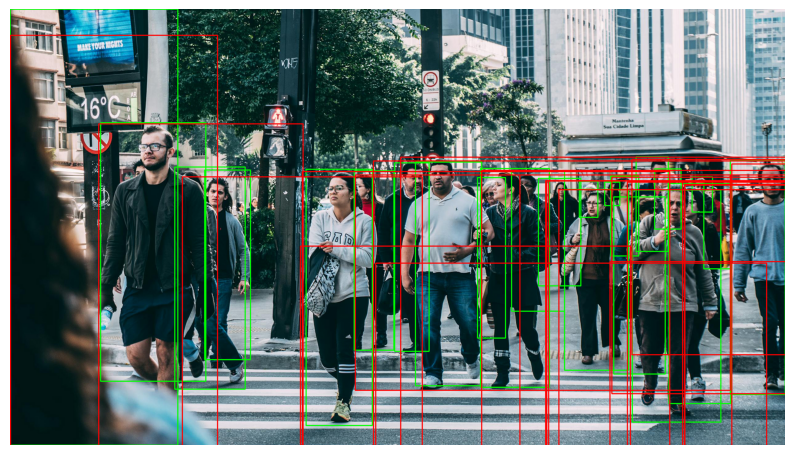

In [ ]:
def visualize_predictions(image_path, ground_truths_path, predictions_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load ground truths
    with open(ground_truths_path) as f:
        ground_truths = json.load(f)

    # Load predictions
    with open(predictions_path) as f:
        predictions = json.load(f)

    # Draw ground truth bounding boxes
    for ann in ground_truths['annotations']:
        x, y, w, h = ann['bbox']
        cv2.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), (0, 255, 0), 2)  # Green for ground truth

    # Draw prediction bounding boxes
    for pred in predictions:
        x, y, w, h = pred['bbox']
        cv2.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)  # Blue for predictions

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

image_path = '/content/drive/MyDrive/datatest/walkpeople2.jpg'
ground_truths_path = '/content/drive/MyDrive/datatest/_annotations.coco.json'
predictions_path = '/content/drive/MyDrive/datatest/predictions.json'

# Visualize the predictions
visualize_predictions(image_path, ground_truths_path, predictions_path)

In [ ]:
video_path = '/content/drive/MyDrive/datatest/video1walkpeople.mp4'

output_path = '/content/drive/MyDrive/datatest/output_video.avi'
process_video(video_path, model, output_path=output_path)

# Tampilkan video yang dihasilkan
display_video(output_path)